In [5]:
from scipy import stats
from scipy.stats import mode
from sklearn import linear_model
from sklearn.datasets import make_classification
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.utils import resample
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

In [2]:
class Voter:
    def __init__(self, model, id):
        self.model = model
        self.id = id
        self.accuracy = []
        self.batch_accuracies = []
        self.CI = (0, 0)

    def partial_fit(self, X, y):
        self.model.partial_fit(X, y)

    def predict(self, X):
        predictions = self.model.predict(X)
        return predictions


class DelegationMechanism:
    def __init__(self):
        self.delegations = {}  # key: delegate_from (id), value: delegate_to (id)

    def delegate(self, from_id, to_id):
        # cycles are impossible with this mechanism, so we don't need to check for them
        self.delegations[from_id] = to_id

    def wilson_score_interval(self, point_wise_accuracies, confidence=0.95):
        ups = sum(point_wise_accuracies)
        downs = len(point_wise_accuracies) - ups
        n = len(point_wise_accuracies)

        # use the specified confidence value to calculate the z-score
        z = stats.norm.ppf(1 - (1 - confidence) / 2)
        p = ups / n

        left = p + 1 / (2 * n) * z * z
        right = z * np.sqrt(p * (1 - p) / n + z * z / (4 * n * n))
        under = 1 + 1 / n * z * z

        return ((left - right) / under, (left + right) / under)

    def calculate_CI(self, voter):
        point_wise_accuracies = voter.accuracy

        # assume the point wise accuracies are a list of bernoulli random variables
        # approximate using the Wilson score interval
        return self.wilson_score_interval(point_wise_accuracies)

    def update_delegations(self, voters):
        # first, we need to recalculate the CI for each voter
        for voter in voters:
            voter.CI = self.calculate_CI(voter)

        # now we need to do two things:
        # 1. ensure all current delegations are still valid. If not, remove them
        # 2. go through the full delegation process
        delegators_to_pop = []
        for (
            delegator,
            delegee,
        ) in self.delegations.items():  # check delegations and break invalid ones
            if delegator.CI[1] > delegee.CI[0]:
                delegators_to_pop.append(delegator)
        for delegator in delegators_to_pop:
            self.delegations.pop(delegator)

        for voter in voters:  # go through the full delegation process
            possible_delegees = []
            gaps = []
            for other_voter in voters:
                # find all voters who are SIGNIFICANTLY better than the current voter. TODO: Could possibly apply a penalty for a high number of delegations
                if other_voter.id != voter.id and (other_voter.CI[0] > voter.CI[1]):
                    possible_delegees.append(other_voter)
                    gaps.append(other_voter.CI[0] - voter.CI[1])
            if len(possible_delegees) > 0:
                # probabilistically delegate based on the gaps
                # larger gaps are more likely to be chosen
                sum_gaps = sum(gaps)
                probabilities = [gap / sum_gaps for gap in gaps]
                delegee = np.random.choice(possible_delegees, p=probabilities)
                self.delegate(voter, delegee)

    def get_gurus(self, voters):
        # find all voters who have not delegated to anyone
        gurus = []
        for voter in voters:
            if voter.id not in self.delegations.keys():
                gurus.append(voter)
        return gurus

## Create Gaussian Data

In [3]:
# Parameters for 5-dimensional Gaussians
n_features = 60  # Number of features for the Gaussian
variance = 1  # Variance of the Gaussian
n_shift_samples = (
    100  # Number of samples to generate for the pre-shift positive and negative classes
)
n_samples = 200  # Total number of samples to generate
mean_shift = 2  # Amount to shift the mean of the positive and negative classes

# Define the mean vectors for the positive and negative classes
mean_vector_positive = np.ones(n_features)
mean_vector_negative = -np.ones(n_features)

# Generate data for the pre-shift positive and negative classes with distinct labels
X_positive_pre_shift = np.random.normal(
    loc=mean_vector_positive,
    scale=np.sqrt(variance),
    size=(n_shift_samples, n_features),
)
y_positive_pre_shift = np.ones(n_shift_samples)  # All positives pre-shift

X_negative_pre_shift = np.random.normal(
    loc=mean_vector_negative,
    scale=np.sqrt(variance),
    size=(n_shift_samples, n_features),
)
y_negative_pre_shift = np.zeros(n_shift_samples)  # All negatives pre-shift

# Generate data for the post-shift positive and negative classes with distinct labels
mean_vector_positive_shifted = (
    mean_vector_positive + mean_shift
)  # Shifted mean for the positive class
mean_vector_negative_shifted = (
    mean_vector_negative + mean_shift
)  # Shifted mean for the negative class

X_positive_post_shift = np.random.normal(
    loc=mean_vector_positive_shifted,
    scale=np.sqrt(variance),
    size=(n_samples - n_shift_samples, n_features),
)
y_positive_post_shift = np.ones(n_samples - n_shift_samples)  # All positives post-shift

X_negative_post_shift = np.random.normal(
    loc=mean_vector_negative_shifted,
    scale=np.sqrt(variance),
    size=(n_samples - n_shift_samples, n_features),
)
y_negative_post_shift = np.zeros(
    n_samples - n_shift_samples
)  # All negatives post-shift

# Combine pre-shift and post-shift datasets into one
X_full = np.vstack(
    (
        X_positive_pre_shift,
        X_negative_pre_shift,
        X_positive_post_shift,
        X_negative_post_shift,
    )
)
y_full = np.hstack(
    (
        y_positive_pre_shift,
        y_negative_pre_shift,
        y_positive_post_shift,
        y_negative_post_shift,
    )
)

# Convert to pandas DataFrame and Series for compatibility with the code snippet
X = pd.DataFrame(X_full, columns=[f"feature_{i}" for i in range(n_features)])
y = pd.Series(y_full, name="target")

# Output the corrected shapes
X.shape, y.shape

((400, 60), (400,))

In [4]:
# # visualize X and y both pre and post shift
# import matplotlib.pyplot as plt

# # show the negative class distribution in one chart on the left (both pre and post shift) and the positive class in another chart on the right (both pre and post shift)
# fig, axs = plt.subplots(1, 2, figsize=(10, 5))
# axs[0].hist(X_negative_pre_shift, bins=100, alpha=0.5, label='pre-shift')
# axs[0].hist(X_negative_post_shift, bins=100, alpha=0.5, label='post-shift')
# axs[0].set_title('Negative Class Distribution')
# #plot vertical line at 0
# axs[0].axvline(x=0, color='black', linestyle='--')
# axs[0].legend()
# axs[1].hist(X_positive_pre_shift, bins=100, alpha=0.5, label='pre-shift')
# axs[1].hist(X_positive_post_shift, bins=100, alpha=0.5, label='post-shift')
# #plot vertical line at 0
# axs[1].axvline(x=0, color='black', linestyle='--')
# axs[1].set_title('Positive Class Distribution')
# axs[1].legend()
# plt.show()

## Train Ensembles

In [5]:
n_voters = 100
voters = []

for i in range(n_voters):
    voters.append(Voter(linear_model.SGDClassifier(), i))

delegation_mechanism = DelegationMechanism()

# full ensemble clf not using the voters
full_ensemble_models = [linear_model.SGDClassifier() for i in range(n_voters)]

# reshape y to be a 2d array
classes = np.unique(y)

batch_size = 10

lDem_accs = []
full_ensemble_accs = []

for i in tqdm(range(0, len(X), batch_size)):
    X_batch = X[i : i + batch_size].values
    y_batch = y[i : i + batch_size].values

    if i == 0:
        # print("initial fit")
        for voter in voters:
            voter.model.partial_fit(X_batch, y_batch, classes=np.unique(y))

        for model in full_ensemble_models:
            model.partial_fit(X_batch, y_batch, classes=np.unique(y))

    else:
        gurus = delegation_mechanism.get_gurus(voters)
        for guru in gurus:  # each guru predicts the batch
            # make predictions on the batch
            predictions = guru.predict(X_batch)
            # we will log the performance of the guru for each data point in the batch
            for j in range(len(predictions)):
                point_wise_accuracy = [1 if predictions[j] == y_batch[j] else 0]
                guru.accuracy.extend(point_wise_accuracy)
            # we will also log the batch accuracy
            guru.batch_accuracies.append(
                sum(point_wise_accuracy) / len(point_wise_accuracy)
            )

        # make a prediction with the liquid democracy ensemble
        ensemble_preds = [
            np.argmax(
                np.bincount(
                    [guru.predict(X_batch[i].reshape(1, -1))[0] for guru in gurus]
                )
            )
            for i in range(len(X_batch))
        ]
        # calculate the accuracy of the ensemble using np.mean
        ensemble_accuracy = np.mean(ensemble_preds == y_batch)
        lDem_accs.append(ensemble_accuracy)

        # make a prediction with the full ensemble
        full_ensemble_preds = [
            np.argmax(
                np.bincount(
                    [
                        model.predict(X_batch[i].reshape(1, -1))[0]
                        for model in full_ensemble_models
                    ]
                )
            )
            for i in range(len(X_batch))
        ]
        # calculate the accuracy of the ensemble using np.mean
        full_ensemble_accuracy = np.mean(full_ensemble_preds == y_batch)
        full_ensemble_accs.append(full_ensemble_accuracy)

        delegation_mechanism.update_delegations(
            voters
        )  # update delegations based on the new accuracies

        gurus = delegation_mechanism.get_gurus(voters)  # fit the new gurus on the batch
        for guru in gurus:
            guru.model.partial_fit(X_batch, y_batch)

        for model in full_ensemble_models:
            model.partial_fit(X_batch, y_batch)

# print(lDem_accs)
# print(full_ensemble_accs)

  0%|          | 0/40 [00:00<?, ?it/s]

100%|██████████| 40/40 [00:25<00:00,  1.58it/s]


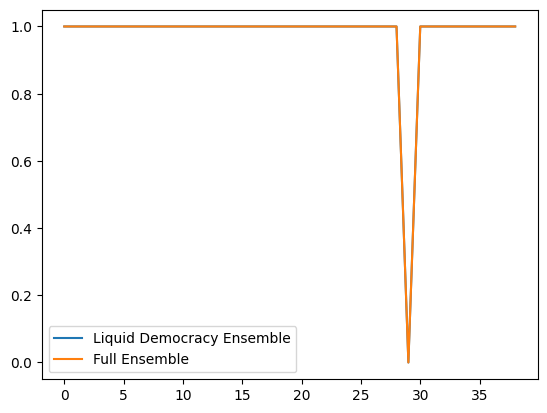

In [7]:
# plot the accuracies of the liquid democracy ensemble and the full ensemble
import matplotlib.pyplot as plt

plt.plot(lDem_accs, label="Liquid Democracy Ensemble")
plt.plot(full_ensemble_accs, label="Full Ensemble")
plt.legend()
plt.show()

## Data set exploration

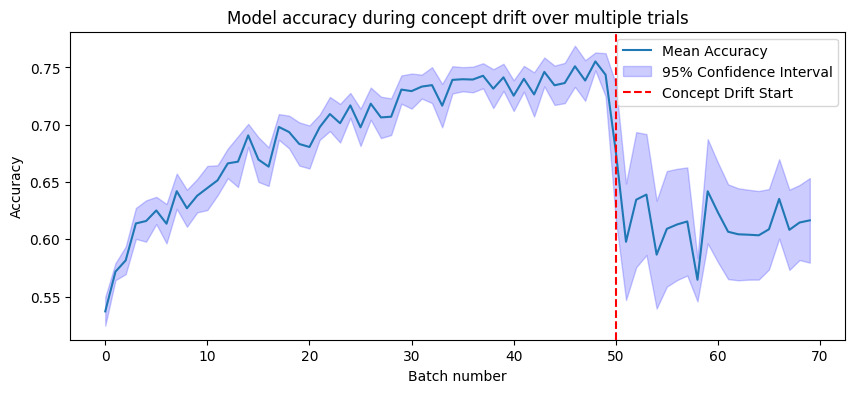

In [1]:


# Set random seed for reproducibility
np.random.seed(42)

# Function to generate dataset with/without concept drift
def generate_dataset(shift=0, samples=10000, features=2000, informative=1500):
    return make_classification(n_samples=samples, n_features=features, n_informative=informative,
                               n_clusters_per_class=1, random_state=42, shift=shift)

# Create synthetic datasets
X, y = generate_dataset(samples=5000)
X_drift, y_drift = generate_dataset(shift=4000, samples=2000)

# Combine datasets
X_stream = np.vstack((X, X_drift))
y_stream = np.hstack((y, y_drift))

# Training parameters
batch_size = 100
iterations = X_stream.shape[0] // batch_size
trials = 10
trial_accuracies = np.zeros((trials, iterations))

# Perform trials
for trial in range(trials):
    sgd = SGDClassifier(random_state=trial)  # New classifier per trial with different seed
    
    # Incremental training with partial fit
    for i in range(iterations):
        start = i * batch_size
        end = start + batch_size
        X_batch, y_batch = X_stream[start:end], y_stream[start:end]
        
        # partial fit on the batch
        sgd.partial_fit(X_batch, y_batch, classes=np.unique(y_stream))
        
        # Evaluate on the entire stream
        y_pred = sgd.predict(X_stream)
        trial_accuracies[trial, i] = accuracy_score(y_stream, y_pred)

# Calculate the mean accuracy and the confidence interval for each batch
mean_accuracies = trial_accuracies.mean(axis=0)
std_error = trial_accuracies.std(axis=0) / np.sqrt(trials)
confidence_intervals = 1.96 * std_error  # 95% confidence interval

# Plotting
plt.figure(figsize=(10, 4))
plt.plot(mean_accuracies, label='Mean Accuracy')
plt.fill_between(range(iterations), 
                 mean_accuracies - confidence_intervals, 
                 mean_accuracies + confidence_intervals, 
                 color='b', alpha=0.2, label='95% Confidence Interval')
plt.axvline(x=X.shape[0] // batch_size, color='r', linestyle='--', label='Concept Drift Start')
plt.xlabel('Batch number')
plt.ylabel('Accuracy')
plt.title('Model accuracy during concept drift over multiple trials')
plt.legend()
plt.show()

In [3]:
def predict_with_ensemble(classifiers, X):
    # Collect predictions from all classifiers
    predictions = np.array([clf.predict(X) for clf in classifiers])
    # Use mode to find the most common prediction for each sample
    majority_vote,_ = mode(predictions, axis=0)
    # print(majority_vote)
    return majority_vote

# Set random seed for reproducibility
np.random.seed(42)

# Function to generate dataset with/without concept drift
def generate_dataset(shift=0, samples=10000, features=8000, informative=7500):
    return make_classification(n_samples=samples, n_features=features, n_informative=informative,
                               n_clusters_per_class=1, random_state=42, shift=shift)

# Create synthetic datasets
X, y = generate_dataset(samples=5000)
X_drift, y_drift = generate_dataset(shift=4000, samples=2000)

# Combine datasets
X_stream = np.vstack((X, X_drift))
y_stream = np.hstack((y, y_drift))

num_clf = 11

# Training parameters
batch_size = 50
iterations = X_stream.shape[0] // batch_size
trials = 10
trial_accuracies = np.zeros((trials, iterations))

# Perform trials
for trial in range(trials):
    # new ensemble per trial with different seed
    ensemble = [SGDClassifier(random_state=i) for i in range(num_clf)]
    
    # Incremental training with partial fit
    for i in range(iterations):
        start = i * batch_size
        end = start + batch_size
        X_batch, y_batch = X_stream[start:end], y_stream[start:end]
        
        # partial fit on the batch
        for clf in ensemble:
            clf.partial_fit(X_batch, y_batch, classes=np.unique(y_stream))
        
        # Evaluate
        y_pred = predict_with_ensemble(ensemble, X_stream)
        trial_accuracies[trial, i] = accuracy_score(y_stream, y_pred)

# Calculate the mean accuracy and the confidence interval for each batch
mean_accuracies = trial_accuracies.mean(axis=0)
std_error = trial_accuracies.std(axis=0) / np.sqrt(trials)
confidence_intervals = 1.96 * std_error  # 95% confidence interval

# Plotting
plt.figure(figsize=(10, 4))
plt.plot(mean_accuracies, label='Mean Accuracy')
plt.fill_between(range(iterations), 
                 mean_accuracies - confidence_intervals, 
                 mean_accuracies + confidence_intervals, 
                 color='b', alpha=0.2, label='95% Confidence Interval')
plt.axvline(x=X.shape[0] // batch_size, color='r', linestyle='--', label='Concept Drift Start')
plt.xlabel('Batch number')
plt.ylabel('Accuracy')
plt.title('Model accuracy during concept drift over multiple trials')
plt.legend()
plt.show()

KeyboardInterrupt: 

In [36]:
# Set random seed for reproducibility
np.random.seed(42)

# Function to generate dataset with/without concept drift
def generate_dataset(shift=0, samples=10000, features=10, informative=7):
    return make_classification(n_samples=samples, n_features=features, n_informative=informative,
                               n_clusters_per_class=4, random_state=42, shift=shift)

# Create synthetic datasets
X, y = generate_dataset(samples=20000)
X_drift, y_drift = generate_dataset(samples=20000)
#apply a shift to the drift dataset
X_drift = X_drift + 20

# Combine datasets
X_stream = np.vstack((X, X_drift))
y_stream = np.hstack((y, y_drift))

100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


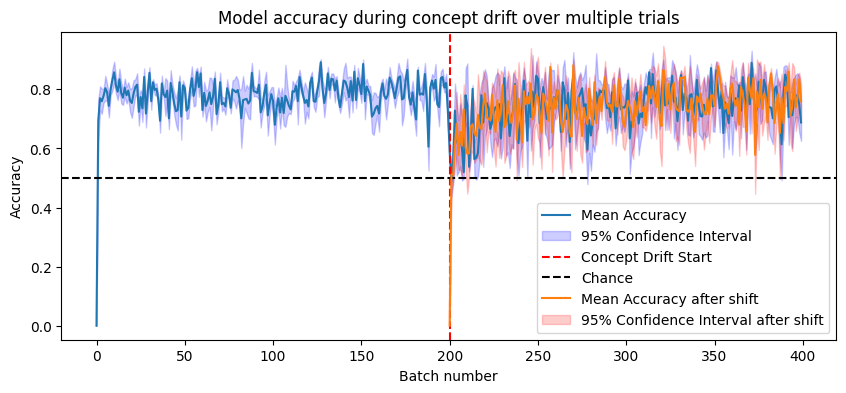

In [38]:
# Training parameters
batch_size = 100
iterations = X_stream.shape[0] // batch_size
trials = 5
trial_accuracies = np.zeros((trials, iterations))

shifted_trial_accuracies = np.zeros((trials, iterations//2))

# Perform trials
for trial in tqdm(range(trials)):
    sgd = SGDClassifier(random_state=trial)  # New classifier per trial with different seed

    shift_sgd = SGDClassifier(random_state=(trial+1)*10)  # New classifier per trial with different seed
    
    # Incremental training with partial fit
    for i in range(iterations):
        start = i * batch_size
        end = start + batch_size
        X_batch, y_batch = X_stream[start:end], y_stream[start:end]

        #if we are in the first iteration, fit the model on the first batch
        if i == 0:
            sgd.partial_fit(X_batch, y_batch, classes=np.unique(y_stream))

        else:   
            # Evaluate on the entire stream
            y_pred = sgd.predict(X_batch)
            trial_accuracies[trial, i] = accuracy_score(y_batch, y_pred)

            sgd.partial_fit(X_batch, y_batch)

        if i == iterations//2:
            shift_sgd.partial_fit(X_batch, y_batch, classes=np.unique(y_stream))

        if i > iterations//2:
            y_pred = shift_sgd.predict(X_batch)
            shifted_trial_accuracies[trial, i - iterations//2] = accuracy_score(y_batch, y_pred)

            shift_sgd.partial_fit(X_batch, y_batch)

# Calculate the mean accuracy and the confidence interval for each batch
mean_accuracies = trial_accuracies.mean(axis=0)
std_error = trial_accuracies.std(axis=0) / np.sqrt(trials)
confidence_intervals = 1.96 * std_error  # 95% confidence interval

mean_shifted_accuracies = shifted_trial_accuracies.mean(axis=0)
std_error_shifted = shifted_trial_accuracies.std(axis=0) / np.sqrt(trials)
confidence_intervals_shifted = 1.96 * std_error_shifted  # 95% confidence interval


# Plotting
plt.figure(figsize=(10, 4))
plt.plot(mean_accuracies, label='Mean Accuracy')
plt.fill_between(range(iterations), 
                 mean_accuracies - confidence_intervals, 
                 mean_accuracies + confidence_intervals, 
                 color='b', alpha=0.2, label='95% Confidence Interval')
plt.axvline(x=X.shape[0] // batch_size, color='r', linestyle='--', label='Concept Drift Start')
plt.xlabel('Batch number')
plt.ylabel('Accuracy')
plt.title('Model accuracy during concept drift over multiple trials')
plt.axhline(y=0.5, color='black', linestyle='--', label='Chance')

#plot thhe sifted accuracies after the shift
plt.plot(range(iterations//2, iterations), mean_shifted_accuracies, label='Mean Accuracy after shift')
plt.fill_between(range(iterations//2, iterations),
                 mean_shifted_accuracies - confidence_intervals_shifted, 
                 mean_shifted_accuracies + confidence_intervals_shifted, 
                 color='r', alpha=0.2, label='95% Confidence Interval after shift')

plt.legend()
plt.show()